In [15]:
files = [
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eybrows quick + garbage_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eyebrows and hold_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\reading outloud-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\smiling-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\squinting-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\blinks_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 1_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 2_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye movements up down-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\noise-labeled-af.csv"
]

In [16]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Parameters
num_channels = 16
window_size = 160
step_size = 30
 


def create_windows(emg_data, labels, window_size, step_size):
    """Generates overlapping windows from EMG data while ensuring complete blinks."""
    X, y, indices = [], [], []
    num_samples = len(emg_data)

    for start in range(0, num_samples - window_size, step_size):
        window_data = emg_data[start:start + window_size, :]
        window_labels = labels[start:start + window_size]

        # Check if there's any '1' in the window
        blink_present = np.any(window_labels == 1)

        # Check if it's a full blink (all values = 1) OR starts and ends with 0
        full_blink = np.all(window_labels == 1)
        no_halfies = (window_labels[0] == 0 and window_labels[-1] == 0)

        # Assign label if a blink is present and either fully contained or full-window
        window_label = 1 if (blink_present and (full_blink or no_halfies)) else 0

        X.append(window_data)
        y.append(window_label)
        indices.append(start)

    return np.array(X), np.array(y), np.array(indices)

# Initialize datasets
train_data, val_data, test_data = [], [], []
train_labels, val_labels, test_labels = [], [], []

for file in files:
    df = pd.read_csv(file)
    df['label'] = df['label'].astype(str)
    df['label'] = df['label'].apply(lambda x: 1 if x.lower() == 'blink' else 0)
    df = df.drop(columns=['timestamp'])

    emg_data = df.iloc[:, :-1].values
    labels = df['label'].values

    X_windows, y_windows, window_indices = create_windows(emg_data, labels, window_size, step_size)
    
    if "blinks_labeled_af.csv" in file:
        blink_indices = np.where(y_windows == 1)[0]
        
        train_end_idx = blink_indices[int(0.7 * len(blink_indices))+2]  # 60% blinks for Train
        val_end_idx = blink_indices[int(0.85 * len(blink_indices))+2]  # 80% blinks for Validation
        
        for i, idx in enumerate(window_indices):
            if i <= train_end_idx:
                train_data.append(X_windows[i])
                train_labels.append(y_windows[i])
            elif i <= val_end_idx:
                val_data.append(X_windows[i])
                val_labels.append(y_windows[i])
            else:
                test_data.append(X_windows[i])
                test_labels.append(y_windows[i])
    else:
        blink_windows = np.where(y_windows == 1)[0]
        assigned_splits = {}
        
        for bw in blink_windows:
            if bw not in assigned_splits:
                split_choice = random.choice(["train", "val", "test"])
                assigned_splits[bw] = split_choice
            else:
                split_choice = assigned_splits[bw]
            
            start_idx = max(0, bw - 5)
            end_idx = min(len(X_windows), bw + 6)
            
            for i in range(start_idx, end_idx):
                if split_choice == "train":
                    train_data.append(X_windows[i])
                    train_labels.append(y_windows[i])
                elif split_choice == "val":
                    val_data.append(X_windows[i])
                    val_labels.append(y_windows[i])
                else:
                    test_data.append(X_windows[i])
                    test_labels.append(y_windows[i])
        
        # Ensure remaining indices exclude assigned blink regions
        assigned_indices = set()
        for bw in blink_windows:
            assigned_indices.update(range(max(0, bw - 5), min(len(X_windows), bw + 6)))
        remaining_indices = list(set(range(len(X_windows))) - assigned_indices)
        
        num_train = int(0.7 * len(remaining_indices))
        num_val = int(0.15 * len(remaining_indices))
        
        train_data.extend([X_windows[i] for i in remaining_indices[:num_train]])
        train_labels.extend([y_windows[i] for i in remaining_indices[:num_train]])
        val_data.extend([X_windows[i] for i in remaining_indices[num_train+4:num_train + num_val]])
        val_labels.extend([y_windows[i] for i in remaining_indices[num_train+4:num_train + num_val]])
        test_data.extend([X_windows[i] for i in remaining_indices[num_train + num_val+4:]])
        test_labels.extend([y_windows[i] for i in remaining_indices[num_train + num_val+4:]])

# Convert lists to numpy arrays
X_train, y_train = np.array(train_data), np.array(train_labels)
X_val, y_val = np.array(val_data), np.array(val_labels)
X_test, y_test = np.array(test_data), np.array(test_labels)

print(f"Final Windows: Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)})")


Final Windows: Train (7363), Validation (1554), Test (1513)


In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

# Basic settings
image_height = 100  # Adjusted to match expected CNN input shape
window_size = 160  # Define the correct window size
num_channels = 16  # Define number of EMG channels
min_val, max_val = -200, 200

# Function to convert EMG signals into a single image
def normalize_and_convert_to_image(signal_window):
    """ Converts an EMG signal window into a single (100, 150) image with max values. """
    normalized_signals = (signal_window - np.min(signal_window)) / (np.max(signal_window) - np.min(signal_window))
    normalized_signals = np.clip(normalized_signals, 0, 1)

    image = np.zeros((image_height, window_size), dtype=np.uint8)
    value_scale = np.linspace(255, 255 - (num_channels - 1) * 10, num_channels, dtype=np.uint8)

    for ch in range(num_channels):
        for t in range(window_size):
            pixel_y = int(normalized_signals[t, ch] * (image_height - 1))
            image[pixel_y, t] = max(image[pixel_y, t], value_scale[ch])

    return image

# Creating new dataset format (Ensure correct reshaping)
X_train_images = np.array([normalize_and_convert_to_image(X_train[i]) for i in range(len(X_train))], dtype=np.uint8)
X_val_images = np.array([normalize_and_convert_to_image(X_val[i]) for i in range(len(X_val))], dtype=np.uint8)
X_test_images = np.array([normalize_and_convert_to_image(X_test[i]) for i in range(len(X_test))], dtype=np.uint8)

# Reshape to match CNN input: (samples, height, width, channels)
X_train_images = X_train_images.reshape(-1, image_height, window_size, 1)
X_val_images = X_val_images.reshape(-1, image_height, window_size, 1)
X_test_images = X_test_images.reshape(-1, image_height, window_size, 1)

# Function to balance classes in training
def batch_oversample(X, y, batch_size=1000):
    """ Performs oversampling based on class distribution in windows. """
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = [], []
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        X_batch = X[start:end].reshape(end - start, -1)
        y_batch = y[start:end]

        if len(np.unique(y_batch)) > 1:
            X_batch_res, y_batch_res = oversampler.fit_resample(X_batch, y_batch)
            X_resampled.append(X_batch_res.reshape(-1, image_height, window_size, 1))
            y_resampled.append(y_batch_res)
        else:
            X_resampled.append(X_batch.reshape(-1, image_height, window_size, 1))
            y_resampled.append(y_batch)

    return np.concatenate(X_resampled, axis=0), np.concatenate(y_resampled, axis=0)

# Perform oversampling
X_train_resampled, y_train_resampled = batch_oversample(X_train_images, y_train, batch_size=2000)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Training data shape: {X_train_resampled.shape}, Labels shape: {y_train_resampled.shape}")
print(f"Class weights: {class_weight_dict}")

# Ensure validation set is correctly shaped
print(f"Validation data shape: {X_val_images.shape}, Labels shape: {y_val.shape}")


Training data shape: (14510, 100, 160, 1), Labels shape: (14510,)
Class weights: {0: 1.0, 1: 1.0}
Validation data shape: (1554, 100, 160, 1), Labels shape: (1554,)


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model Parameters
input_shape = (image_height, window_size, 1)  # Single input image (25x150, 1 channel)
num_classes = 2  # Binary classification (Blink or No Blink)

def build_single_channel_cnn():
    """CNN Model for Single-Channel EMG-Based Blink Detection"""
    inputs = keras.Input(shape=input_shape)  # Single grayscale image input
    
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)  # Reduce overfitting
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Create the modified model
single_channel_cnn = build_single_channel_cnn()
single_channel_cnn.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 160, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 160, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 40, 64)        1849

In [19]:
# Train the CNN with memory-efficient data loading
history = single_channel_cnn.fit(
    X_train_resampled, y_train_resampled,
    epochs=1, batch_size=32,
    validation_data=(X_val_images, y_val),
    class_weight=class_weight_dict  # Handles any remaining imbalance
)

454/454 [==============================] - 71s 156ms/step - loss: 0.2107 - accuracy: 0.9878 - val_loss: 0.0377 - val_accuracy: 0.9916


In [23]:
from sklearn.metrics import classification_report

y_pred_probs = single_channel_cnn.predict(X_val_images)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_val, y_pred))

49/49 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1525
           1       0.77      0.79      0.78        29

    accuracy                           0.99      1554
   macro avg       0.88      0.89      0.89      1554
weighted avg       0.99      0.99      0.99      1554



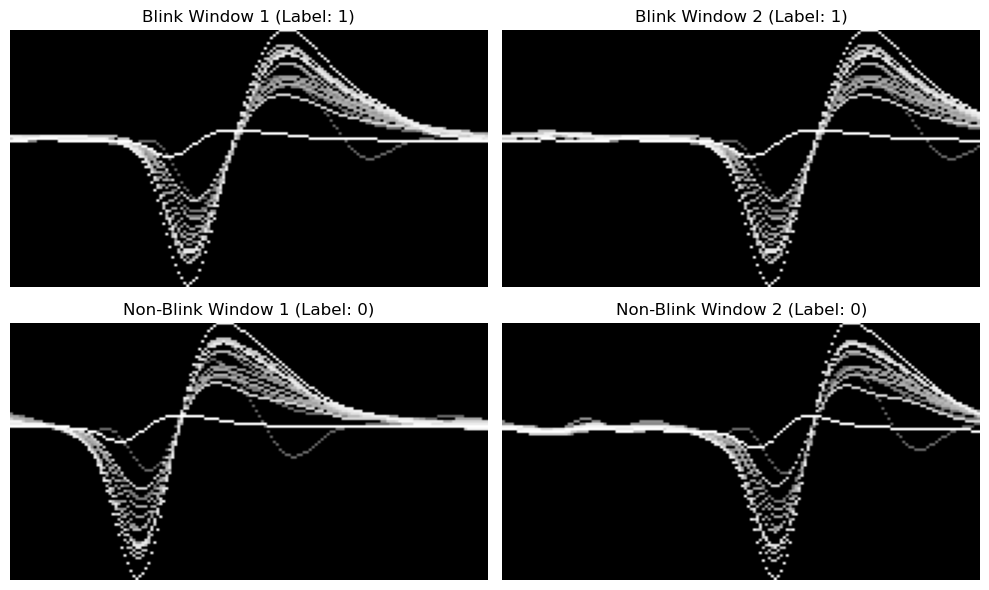

In [20]:
import matplotlib.pyplot as plt
n=0
# Plot 2 windows labeled 1 and 2 labeled 0
blink_indices = np.where(y_train_resampled == 1)[0][n:n+2]
non_blink_indices = np.where(y_train_resampled == 1)[0][n+2:n+4]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, idx in enumerate(blink_indices):
    ax = axes[0, i]
    ax.imshow(X_train_resampled[idx, :, :, 0], cmap='gray', aspect='auto')  # Show first channel
    ax.set_title(f"Blink Window {i+1} (Label: 1)")
    ax.axis('off')

for i, idx in enumerate(non_blink_indices):
    ax = axes[1, i]
    ax.imshow(X_train_resampled[idx, :, :, 0], cmap='gray', aspect='auto')  # Show first channel
    ax.set_title(f"Non-Blink Window {i+1} (Label: 0)")
    ax.axis('off')

plt.tight_layout()
plt.show()